In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns
import random
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [2]:
data = pd.read_csv('15.IP_traffic.csv')

In [3]:
data

,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,...,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
0,172.19.1.46-10.200.7.7-52422-3128-6,172.19.1.46,52422,10.200.7.7,3128,6,26/04/201711:11:17,45523,22,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
1,172.19.1.46-10.200.7.7-52422-3128-6,10.200.7.7,3128,172.19.1.46,52422,6,26/04/201711:11:17,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
2,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,1,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
3,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,217,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
4,192.168.72.43-10.200.7.7-55961-3128-6,192.168.72.43,55961,10.200.7.7,3128,6,26/04/201711:11:17,78068,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577291,10.200.7.199-98.138.79.73-42135-443-6,98.138.79.73,443,10.200.7.199,42135,6,15/05/201705:43:40,2290821,5,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,91,SSL
3577292,10.200.7.217-98.138.79.73-51546-443-6,98.138.79.73,443,10.200.7.217,51546,6,15/05/201705:46:10,24,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,91,SSL
3577293,10.200.7.218-98.138.79.73-44366-443-6,98.138.79.73,443,10.200.7.218,44366,6,15/05/201705:45:39,2591653,6,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,91,SSL
3577294,10.200.7.195-98.138.79.73-52341-443-6,98.138.79.73,443,10.200.7.195,52341,6,15/05/201705:45:59,2622421,4,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,91,SSL


In [4]:
data['Label'].value_counts()

BENIGN    3577296
Name: Label, dtype: int64

In [5]:
#checking 20-80% rule here 
np.cumsum((data['ProtocolName'].value_counts()/data.shape[0]).head(15))

GOOGLE            0.268110
HTTP              0.459242
HTTP_PROXY        0.633454
SSL               0.746636
HTTP_CONNECT      0.835397
YOUTUBE           0.883137
AMAZON            0.907423
MICROSOFT         0.922716
GMAIL             0.933971
WINDOWS_UPDATE    0.943607
SKYPE             0.952176
FACEBOOK          0.960292
DROPBOX           0.967309
YAHOO             0.973255
TWITTER           0.978359
Name: ProtocolName, dtype: float64

In [6]:
#by taking this data itself will describe the whole dataset.
print(np.cumsum((data['ProtocolName'].value_counts()/data.shape[0]).tail(62)))
#other applications are considered as low or rarely used. Since the cumulative sum is less then 2%
prtnthelping = list(data['ProtocolName'].value_counts().tail(78-16).index)

MSN              0.004047
CONTENT_FLASH    0.006448
APPLE            0.008577
OFFICE_365       0.010238
WHATSAPP         0.011522
                   ...   
STARCRAFT        0.017520
QQ               0.017521
99TAXI           0.017521
SOCKS            0.017521
NFS              0.017522
Name: ProtocolName, Length: 62, dtype: float64


In [7]:
#dropping the entries with this applications 
print(data[data['ProtocolName'].isin(prtnthelping)].shape, data.shape)

(62680, 87) (3577296, 87)


In [8]:
data.describe()

,Source.Port,Destination.Port,Protocol,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets,Fwd.Packet.Length.Max,Fwd.Packet.Length.Min,...,min_seg_size_forward,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,L7Protocol
count,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,...,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06,3.577296e+06
mean,3.799938e+04,1.204246e+04,6.005508e+00,2.544247e+07,6.237799e+01,6.534083e+01,4.683323e+04,8.445742e+04,5.123645e+02,9.340408e+00,...,2.569738e+01,2.981990e+05,1.836406e+05,5.229372e+05,1.676336e+05,8.524211e+06,1.370991e+06,9.743845e+06,7.252097e+06,1.029508e+02
std,2.201713e+04,2.044916e+04,3.274574e-01,4.014430e+07,1.094086e+03,1.108092e+03,1.816196e+06,2.124319e+06,1.039319e+03,8.299983e+01,...,6.025989e+00,2.349390e+06,1.325838e+06,3.266508e+06,2.064219e+06,1.706568e+07,4.814474e+06,1.888557e+07,1.600754e+07,5.129198e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,3.697000e+03,4.430000e+02,6.000000e+00,6.280000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.100000e+01
50%,4.937700e+04,3.128000e+03,6.000000e+00,5.847295e+05,6.000000e+00,5.000000e+00,4.430000e+02,2.080000e+02,2.060000e+02,0.000000e+00,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.260000e+02
75%,5.379900e+04,3.128000e+03,6.000000e+00,4.500153e+07,1.500000e+01,1.500000e+01,1.769000e+03,3.629000e+03,6.130000e+02,6.000000e+00,...,3.200000e+01,4.500000e+01,0.000000e+00,5.700000e+01,2.000000e+00,7.506747e+06,0.000000e+00,8.034389e+06,5.369712e+06,1.300000e+02
max,6.553400e+04,6.553400e+04,1.700000e+01,1.200000e+08,4.531900e+05,5.421960e+05,6.780236e+08,1.345796e+09,3.283200e+04,1.606000e+04,...,5.230000e+02,1.146950e+08,7.297136e+07,1.146950e+08,1.146950e+08,1.200000e+08,7.738746e+07,1.200000e+08,1.200000e+08,2.220000e+02


In [10]:
data['Source.IP'].value_counts()

10.200.7.218      295431
10.200.7.217      268048
10.200.7.199      224754
10.200.7.195      191107
10.200.7.194      181815
                   ...  
200.24.59.20           1
192.168.81.42          1
208.93.230.179         1
208.93.230.191         1
200.13.237.174         1
Name: Source.IP, Length: 6566, dtype: int64

In [11]:
data[data['Source.IP'].str.contains('10.200.7.') | (data['Source.IP'].str.contains('192.168.')) ].shape[0]/data.shape[0]

0.9130974903949799

In [12]:
hiprof =  list(data[data['Flow.Bytes.s'] > (1024*8*2048)]['Source.IP'].value_counts().index)
med1prof = list(data[(data['Flow.Bytes.s'] < (1024*8*2048)) & (data['Flow.Bytes.s'] > (1024*8*1024))]['Source.IP'].value_counts().index)
med2prod =  list(data[(data['Flow.Bytes.s'] < (1024*8*1024)) & (data['Flow.Bytes.s'] > (1024*8*256))]['Source.IP'].value_counts().index)
lowprof = list(data[(data['Flow.Bytes.s'] < (1024*8*256))]['Source.IP'].value_counts().index)

In [13]:
def labels(x):
    if(hiprof.count(x)):
        return 3
    elif(med1prof.count(x)):
        return 2
    elif(med2prod.count(x)):
        return 1
    else:
        return 0
data['labels'] = data['Source.IP'].apply(lambda x: labels(x))

In [14]:
data[data['Source.IP'].str.contains('192.168.')]['Source.IP'].value_counts()[data[data['Source.IP'].str.contains('192.168.')]['Source.IP'].value_counts() > 3000]

192.168.180.37     30209
192.168.90.98      17768
192.168.180.14     16733
192.168.112.14     10002
192.168.90.65       8852
                   ...  
192.168.220.177     3095
192.168.29.32       3095
192.168.220.153     3093
192.168.90.104      3052
192.168.220.154     3003
Name: Source.IP, Length: 72, dtype: int64

In [15]:
prtin = data[data['Source.IP'].str.contains('10.200.7.') | (data['Source.IP'].str.contains('192.168.'))]['ProtocolName'].value_counts().head(16).index

In [16]:
data[~data['ProtocolName'].isin(prtin)]

,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,...,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName,labels
101,213.239.207.69-10.200.7.196-80-35706-6,10.200.7.196,35706,213.239.207.69,80,6,26/04/201711:11:17,661481,8,6,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,BENIGN,40,CONTENT_FLASH,3
195,213.239.207.69-10.200.7.196-80-35709-6,10.200.7.196,35709,213.239.207.69,80,6,26/04/201711:11:18,588186,10,8,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,BENIGN,40,CONTENT_FLASH,3
255,192.168.81.7-10.200.7.6-51111-3128-6,192.168.81.7,51111,10.200.7.6,3128,6,26/04/201711:11:19,302194,3,4,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,BENIGN,121,DROPBOX,3
278,213.239.207.69-10.200.7.196-80-35715-6,10.200.7.196,35715,213.239.207.69,80,6,26/04/201711:11:19,658365,8,6,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,BENIGN,40,CONTENT_FLASH,3
332,213.239.207.69-10.200.7.196-80-35719-6,10.200.7.196,35719,213.239.207.69,80,6,26/04/201711:11:19,592944,8,5,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,BENIGN,40,CONTENT_FLASH,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3575534,192.168.60.44-10.200.7.4-58383-3128-6,192.168.60.44,58383,10.200.7.4,3128,6,15/05/201705:33:56,103323978,58,67,...,14914879.0,326645.0,1.616919e+07,1.013180e+07,26674290.0,5722690.0,BENIGN,142,WHATSAPP,3
3575538,192.168.60.44-10.200.7.4-58383-3128-6,192.168.60.44,58383,10.200.7.4,3128,6,15/05/201705:35:59,111976075,15,13,...,1979642.0,200155.0,1.760099e+07,6.946779e+06,26062810.0,9018370.0,BENIGN,142,WHATSAPP,3
3575540,192.168.60.44-10.200.7.4-58383-3128-6,192.168.60.44,58383,10.200.7.4,3128,6,15/05/201705:38:13,96221096,17,18,...,2389920.0,326584.0,1.782916e+07,6.615398e+06,27673723.0,12041756.0,BENIGN,142,WHATSAPP,3
3575665,192.168.72.65-10.200.7.7-49657-3128-6,192.168.72.65,49657,10.200.7.7,3128,6,15/05/201705:34:16,768,2,0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,BENIGN,140,APPLE,3


In [19]:
data.columns

Index(['Flow.ID', 'Source.IP', 'Source.Port', 'Destination.IP',
       'Destination.Port', 'Protocol', 'Timestamp', 'Flow.Duration',
       'Total.Fwd.Packets', 'Total.Backward.Packets',
       'Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets',
       'Fwd.Packet.Length.Max', 'Fwd.Packet.Length.Min',
       'Fwd.Packet.Length.Mean', 'Fwd.Packet.Length.Std',
       'Bwd.Packet.Length.Max', 'Bwd.Packet.Length.Min',
       'Bwd.Packet.Length.Mean', 'Bwd.Packet.Length.Std', 'Flow.Bytes.s',
       'Flow.Packets.s', 'Flow.IAT.Mean', 'Flow.IAT.Std', 'Flow.IAT.Max',
       'Flow.IAT.Min', 'Fwd.IAT.Total', 'Fwd.IAT.Mean', 'Fwd.IAT.Std',
       'Fwd.IAT.Max', 'Fwd.IAT.Min', 'Bwd.IAT.Total', 'Bwd.IAT.Mean',
       'Bwd.IAT.Std', 'Bwd.IAT.Max', 'Bwd.IAT.Min', 'Fwd.PSH.Flags',
       'Bwd.PSH.Flags', 'Fwd.URG.Flags', 'Bwd.URG.Flags', 'Fwd.Header.Length',
       'Bwd.Header.Length', 'Fwd.Packets.s', 'Bwd.Packets.s',
       'Min.Packet.Length', 'Max.Packet.Length', 'Packet.Length.Mean',
  

# 1. less data/commonly consuming apps
# 2. commomnly used apps
# 3. high priority needed apps

In [20]:
data['L7Protocol'].value_counts()

126    959110
7      683734
131    623210
91     404883
130    317526
        ...  
213         3
48          2
202         1
172         1
11          1
Name: L7Protocol, Length: 78, dtype: int64

In [23]:
data1 =data[['Source.IP','Source.Port','Flow.Bytes.s','Average.Packet.Size','L7Protocol','ProtocolName','labels']]

In [24]:
data1

,Source.IP,Source.Port,Flow.Bytes.s,Average.Packet.Size,L7Protocol,ProtocolName,labels
0,172.19.1.46,52422,2.428355e+06,1435.740260,131,HTTP_PROXY,2
1,10.200.7.7,3128,1.200000e+07,9.000000,131,HTTP_PROXY,3
2,50.31.185.39,80,6.740000e+08,337.000000,7,HTTP,3
3,50.31.185.39,80,0.000000e+00,0.000000,7,HTTP,3
4,192.168.72.43,55961,1.378286e+04,321.000000,131,HTTP_PROXY,3
...,...,...,...,...,...,...,...
3577291,98.138.79.73,443,1.203935e+03,373.000000,91,SSL,3
3577292,98.138.79.73,443,6.033333e+07,579.200000,91,SSL,3
3577293,98.138.79.73,443,2.078210e+03,544.272727,91,SSL,3
3577294,98.138.79.73,443,1.137880e+03,466.285714,91,SSL,3


In [25]:
data1['labels'].value_counts()

3    3265875
2     203119
0      67315
1      40987
Name: labels, dtype: int64

C:\Users\ST-0006\anaconda3\envs\keras_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


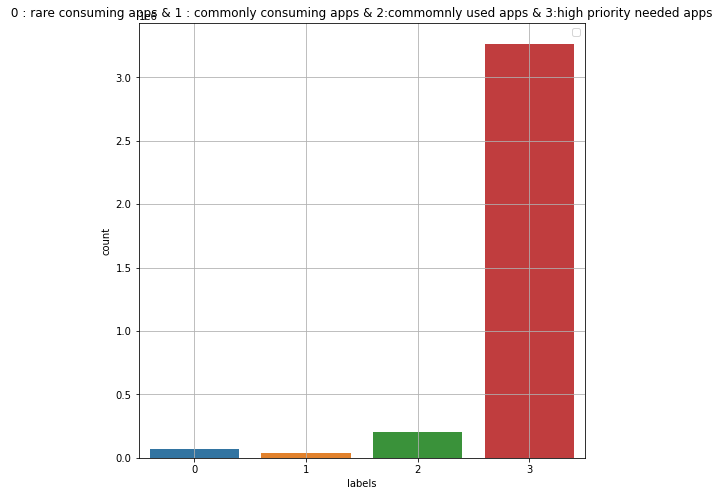

In [30]:
plt.figure(1,(8,8))
sns.countplot(data['labels'])
plt.grid()
plt.legend()
plt.title(' 0 : rare consuming apps & 1 : commonly consuming apps & 2:commomnly used apps & 3:high priority needed apps ')
plt.show()
print(' ')


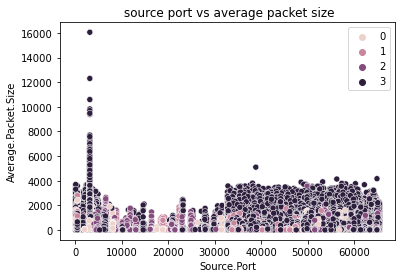

In [31]:
sns.scatterplot(x=data['Source.Port'],y=data['Average.Packet.Size'],hue=data['labels'])
plt.legend() 
plt.title(' source port vs average packet size')
plt.show()

In [33]:
from sklearn.utils import resample
# Separate majority and minority classes
df_0 = data1[data1['labels']== 0]
df_1 = data1[data1['labels']== 1]
df_2 = data1[data1['labels']== 2]
df_3 = data1[data1['labels']== 3]
 
# Downsample majority class and upsample the minority class
df0_0 = resample(df_0, replace=True,n_samples=1000,random_state=123) 
df1_1 = resample(df_1, replace=True,n_samples=1000,random_state=123) 
df2_2 = resample(df_2, replace=True,n_samples=1000,random_state=123) 
df3_3 = resample(df_3, replace=True,n_samples=1000,random_state=123) 
 
# Combine minority class with downsampled majority class
df_upsampled = pd.concat([df0_0,df1_1,df2_2,df3_3])
 
# Display new class counts
df_upsampled['labels'].value_counts()

0    1000
1    1000
2    1000
3    1000
Name: labels, dtype: int64

C:\Users\ST-0006\anaconda3\envs\keras_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


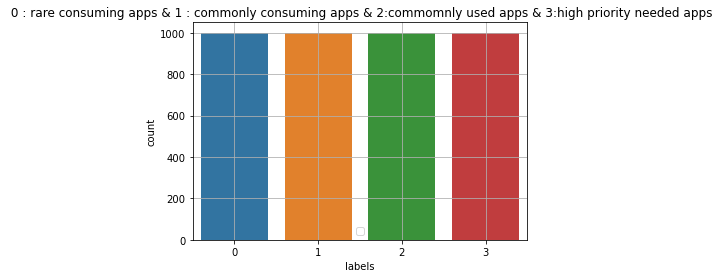

In [36]:
sns.countplot(df_upsampled['labels'])
plt.grid()
plt.legend()
plt.title(' 0 : rare consuming apps & 1 : commonly consuming apps & 2:commomnly used apps & 3:high priority needed apps')
plt.show()

In [37]:
# shuffle the DataFrame rows 
df = df_upsampled.sample(frac = 1)

In [38]:
df

,Source.IP,Source.Port,Flow.Bytes.s,Average.Packet.Size,L7Protocol,ProtocolName,labels
1973534,192.168.10.25,49653,7.605326,29.176471,126,GOOGLE,2
3183176,74.119.118.66,80,59.051945,197.400000,7,HTTP,0
3308335,192.168.60.51,49709,2151.308713,9.000000,175,FTP_DATA,1
3458897,52.20.156.183,443,3.835706,79.250000,178,AMAZON,1
1075820,192.168.102.14,54584,2941.811000,133.750000,126,GOOGLE,1
...,...,...,...,...,...,...,...
675355,10.230.1.221,49409,130434.782609,9.000000,131,HTTP_PROXY,2
1656546,192.168.195.34,57846,5037.102021,98.428571,126,GOOGLE,2
3023497,192.168.72.46,51169,4.083386,16.750000,126,GOOGLE,2
1123858,34.194.71.39,443,10.950370,74.777780,178,AMAZON,0


In [39]:
#Removing duplicates
df = df.drop_duplicates()

In [40]:
from sklearn.preprocessing import LabelEncoder

In [41]:
columns=df.columns
label_encoder=LabelEncoder()
for cols in columns:
   # print(cols)
    if(isinstance(df[cols].values[0],str)):
        df[cols]=label_encoder.fit_transform(df[cols].values)

C:\Users\ST-0006\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
df

,Source.IP,Source.Port,Flow.Bytes.s,Average.Packet.Size,L7Protocol,ProtocolName,labels
1973534,255,49653,7.605326,29.176471,126,13,2
3183176,1149,80,59.051945,197.400000,7,15,0
3308335,764,49709,2151.308713,9.000000,175,11,1
3458897,1060,443,3.835706,79.250000,178,0,1
1075820,300,54584,2941.811000,133.750000,126,13,1
...,...,...,...,...,...,...,...
675355,28,49409,130434.782609,9.000000,131,17,2
1656546,540,57846,5037.102021,98.428571,126,13,2
3023497,808,51169,4.083386,16.750000,126,13,2
1123858,1013,443,10.950370,74.777780,178,0,0


In [47]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [48]:
x

,Source.IP,Source.Port,Flow.Bytes.s,Average.Packet.Size,L7Protocol,ProtocolName
1973534,255,49653,7.605326,29.176471,126,13
3183176,1149,80,59.051945,197.400000,7,15
3308335,764,49709,2151.308713,9.000000,175,11
3458897,1060,443,3.835706,79.250000,178,0
1075820,300,54584,2941.811000,133.750000,126,13
...,...,...,...,...,...,...
675355,28,49409,130434.782609,9.000000,131,17
1656546,540,57846,5037.102021,98.428571,126,13
3023497,808,51169,4.083386,16.750000,126,13
1123858,1013,443,10.950370,74.777780,178,0


In [46]:
y

1973534    2
3183176    0
3308335    1
3458897    1
1075820    1
          ..
675355     2
1656546    2
3023497    2
1123858    0
2460786    3
Name: labels, Length: 3916, dtype: int64

In [50]:

from sklearn.model_selection import train_test_split

In [51]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,stratify=y ,random_state=30)

In [52]:
x_train

,Source.IP,Source.Port,Flow.Bytes.s,Average.Packet.Size,L7Protocol,ProtocolName
2965989,324,63912,8.810781,37.437500,131,17
3344796,11,59816,0.000000,0.000000,7,15
3539219,457,34139,80.608825,67.218310,131,17
912544,18,3128,75000.000000,9.000000,131,17
2967662,389,1627,46.902131,122.526316,131,17
...,...,...,...,...,...,...
1426010,14,44768,0.000000,0.000000,126,13
2799211,407,49864,19.505034,34.177778,131,17
1717665,10,41714,190.074017,22.555556,91,27
3528175,223,80,0.000000,0.000000,7,15


In [95]:
x_test.to_csv('ip_traffic_test.csv',index = False)

In [53]:
y_train

2965989    2
3344796    3
3539219    1
912544     3
2967662    2
          ..
1426010    3
2799211    1
1717665    3
3528175    0
2688575    1
Name: labels, Length: 2937, dtype: int64

In [54]:
print(x_train.shape)
print(y_test.shape)

(2937, 6)
(979,)


In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV

In [59]:

dept = [1, 5, 10, 50, 100, 500,800, 1000]
min_samples =  [5, 10, 100, 500]


param_grid={'min_samples_split':min_samples , 'max_depth':dept}
clf = DecisionTreeClassifier()
model = GridSearchCV(clf,param_grid,scoring='accuracy',n_jobs=-1,cv=4)
model.fit(x_train,y_train)
print("optimal min_samples_split",model.best_estimator_.min_samples_split)
print("optimal max_depth",model.best_estimator_.max_depth)

optimal min_samples_split 5
optimal max_depth 50


***********************************
the accuracy on testing data 0.7946884576098059
the accuracy on training data 0.964930200885257
***********************************


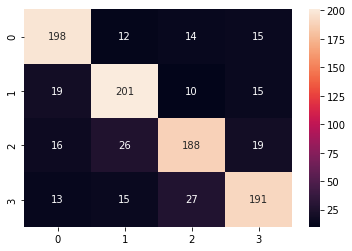

In [61]:
#Testing AUC on Test data
dt = DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth =50,min_samples_split =5)

dt.fit(x_train,y_train)


#predict on test data and train data
 
y_predtestd = dt.predict(x_test)
y_predtraind = dt.predict(x_train)

print('*'*35)

#accuracy on training and testing data

print('the accuracy on testing data',accuracy_score(y_test,y_predtestd))
print('the accuracy on training data',accuracy_score(y_train,y_predtraind))
train0 = accuracy_score(y_train,y_predtraind)
test0 = accuracy_score(y_test,y_predtestd)

print('*'*35)


# Code for drawing seaborn heatmaps

cm = pd.DataFrame(confusion_matrix(y_test, y_predtestd.round()) )
fig = plt.figure( )
heatmap = sns.heatmap(cm, annot=True, fmt="d")

In [92]:
import pickle
filename = r'C:\Users\ST-0006\Documents\dont touch\IPtraffic\ip_dtc.pkl'
pickle.dump(dt, open(filename, 'wb'))

In [63]:
original = []
for i in y_test[:20]:
  if i == 0:
    k = 'rare'
    original.append(k)
  elif i == 1:
    k = 'commonly consumed'
    original.append(k)
  elif i == 2:
    k = 'commonly used'
    original.append(k)
  else:
    k = 'high priority'
    original.append(k)

In [64]:

predicted =dt.predict(x_test[:20])
pred = []

for i in y_test[:20]:
  if i == 0:
    k = 'rare'
    pred.append(k)
  elif i == 1:
    k = 'commonly consumed'
    pred.append(k)
  elif i == 2:
    k = 'commonly used'
    pred.append(k)
  else:
    k = 'high priority'
    pred.append(k)
# # Creating a data frame
dfr = pd.DataFrame(list(zip(original, pred,)), 
               columns =['original_Classlabel', 'predicted_classlebel'])
dfr

,original_Classlabel,predicted_classlebel
0,commonly used,commonly used
1,rare,rare
2,rare,rare
3,commonly used,commonly used
4,commonly used,commonly used
5,commonly consumed,commonly consumed
6,commonly consumed,commonly consumed
7,high priority,high priority
8,high priority,high priority
9,high priority,high priority


In [88]:
all_model_result = pd.DataFrame(columns=['Algorithm', 'Classifier' , 'Train-Accuracy', 'Test-Accuracy' ])
new = ['Decision tree ','decision tree-Classifier',train0, test0]
all_model_result.loc[0] = new

## Support Vector Machine

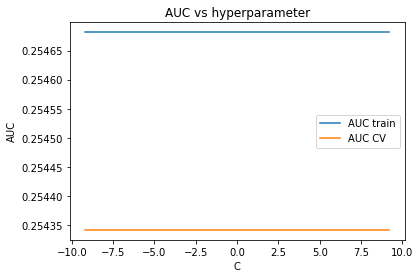

optimal C for which auc is maximum :  10000


In [65]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
import math
C = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

train_auc = []
cv_auc = []

for i in C:
    model = SVC(C=i,gamma=50) 
    clf = CalibratedClassifierCV(model, cv=3)
    clf.fit(x_train,y_train)
    prob_cv = clf.predict(x_test)
    cv_auc.append(accuracy_score(y_test,prob_cv))
    prob_train = clf.predict(x_train)
    train_auc.append(accuracy_score(y_train,prob_train))
optimal_C= C[cv_auc.index(max(cv_auc))]
C=[math.log(x) for x in C]

#plot auc vs alpha
x = plt.subplot( )
x.plot(C, train_auc, label='AUC train')
x.plot(C, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal C for which auc is maximum : ',optimal_C)

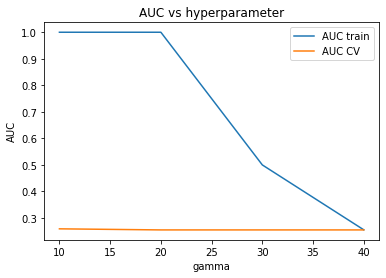

optimal gamma for which auc is maximum :  10


In [66]:
gamma = [10,20,30,30,40]

train_auc = []
cv_auc = []

for i in gamma:
    model = SVC(C=1000,gamma=i) 
    clf = CalibratedClassifierCV(model, cv=3)
    clf.fit(x_train,y_train)
    prob_cv = clf.predict(x_test)
    cv_auc.append(accuracy_score(y_test,prob_cv))
    prob_train = clf.predict(x_train)
    train_auc.append(accuracy_score(y_train,prob_train))
optimal_gamma= gamma[cv_auc.index(max(cv_auc))]
# C=[math.log(x) for x in C]

#plot auc vs alpha
x = plt.subplot( )
x.plot(gamma, train_auc, label='AUC train')
x.plot(gamma, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('gamma')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal gamma for which auc is maximum : ',optimal_gamma)

***********************************
the accuracy on testing data 0.254341164453524
the accuracy on training data 1.0
***********************************


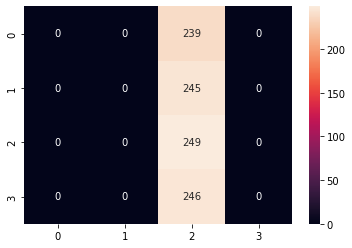

In [68]:
#Testing AUC on Test data
svc = SVC(C=optimal_C,gamma=optimal_gamma)

svc.fit(x_train,y_train)

#predict on test data and train data
 
y_predtests = svc.predict(x_test)
y_predtrains = svc.predict(x_train)

print('*'*35)

#accuracy on training and testing data

print('the accuracy on testing data',accuracy_score(y_test,y_predtests))
print('the accuracy on training data',accuracy_score(y_train,y_predtrains))
train3 = accuracy_score(y_train,y_predtrains)
test3 = accuracy_score(y_test,y_predtests)

print('*'*35)


# Code for drawing seaborn heatmaps

cm = pd.DataFrame(confusion_matrix(y_test, y_predtests.round()) )
fig = plt.figure( )
heatmap = sns.heatmap(cm, annot=True, fmt="d")

In [89]:
new = ['Support vector machine ','support vector-Classifier',train3, test3]
all_model_result.loc[1] = new

In [93]:
filename = r'C:\Users\ST-0006\Documents\dont touch\IPtraffic\ip_svc.pkl'
pickle.dump(dt, open(filename, 'wb'))

## random forest 

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV

dept = [1, 5, 10, 50, 100, 500, 1000]
n_estimators =  [20, 40, 60, 80, 100, 120]


param_grid={'n_estimators':n_estimators , 'max_depth':dept}
clf = RandomForestClassifier()
model = GridSearchCV(clf,param_grid,scoring='accuracy',n_jobs=-1,cv=3)
model.fit(x_train,y_train)
print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)
optimal_n_estimators = model.best_estimator_.n_estimators
optimal_max_depth = model.best_estimator_.max_depth

optimal n_estimators 80
optimal max_depth 1000


***********************************
the accuracy on testing data 0.7170582226762002
the accuracy on training data 1.0
***********************************


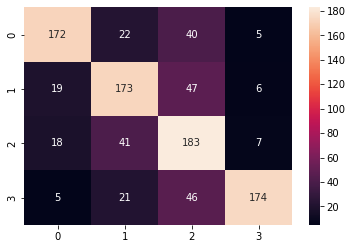

In [82]:
#Testing AUC on Test data
rf = RandomForestClassifier(criterion='entropy',max_depth = optimal_max_depth,n_estimators =optimal_n_estimators)

rf.fit(x_train,y_train)

#predict on test data and train data
 
y_predtest = rf.predict(x_test)
y_predtrain = rf.predict(x_train)

print('*'*35)

#accuracy on training and testing data

print('the accuracy on testing data',accuracy_score(y_test,y_predtest))
print('the accuracy on training data',accuracy_score(y_train,y_predtrain))
train1 = accuracy_score(y_train,y_predtrain)
test1 = accuracy_score(y_test,y_predtest)

print('*'*35)


# Code for drawing seaborn heatmaps

cm = pd.DataFrame(confusion_matrix(y_test, y_predtest.round()) )
fig = plt.figure( )
heatmap = sns.heatmap(cm, annot=True, fmt="d")

In [83]:
original = []
for i in y_test[:20]:
  if i == 0:
    k = 'rare'
    original.append(k)
  elif i == 1:
    k = 'commonly consumed'
    original.append(k)
  elif i == 2:
    k = 'commonly used'
    original.append(k)
  else:
    k = 'high priority'

In [84]:

predicted =rf.predict(x_test[:20])
pred = []

for i in y_test[:20]:
  if i == 0:
    k = 'rare'
    pred.append(k)
  elif i == 1:
    k = 'commonly consumed'
    pred.append(k)
  elif i == 2:
    k = 'commonly used'
    pred.append(k)
  else:
    k = 'high priority'
    pred.append(k)
# # Creating a data frame
dfr = pd.DataFrame(list(zip(original, pred,)), 
               columns =['original_Classlabel', 'predicted_classlebel'])
dfr

,original_Classlabel,predicted_classlebel
0,commonly used,commonly used
1,rare,rare
2,rare,rare
3,commonly used,commonly used
4,commonly used,commonly used
5,commonly consumed,commonly consumed
6,commonly consumed,commonly consumed
7,commonly used,high priority
8,commonly consumed,high priority
9,commonly used,high priority


In [94]:
filename = r'C:\Users\ST-0006\Documents\dont touch\IPtraffic\ip_rf.pkl'
pickle.dump(dt, open(filename, 'wb'))

In [90]:
new = ['random forest ','random forest-Classifier',train1, test1]
all_model_result.loc[2] = new

In [91]:
all_model_result

,Algorithm,Classifier,Train-Accuracy,Test-Accuracy
0,Decision tree,decision tree-Classifier,0.96493,0.794688
1,Support vector machine,support vector-Classifier,1.00000,0.254341
2,random forest,random forest-Classifier,1.00000,0.717058
